# Natural Language Processing Project
## NLP Course @ Politecnico di Milano 2024/2025 - Prof. Mark Carman
### Topic 8: Medical Question Answering
Dataset: 
* PubMedQA [link](https://huggingface.co/datasets/qiaojin/PubMedQA )

Reference paper:
* PubMedQA: A Dataset for Biomedical Research Question Answering [Link](https://arxiv.org/pdf/1909.06146)

## Group members:

* Ketrin Mehmeti
* Giulia Ghiazza
* Leonardo Giorgio Franco
* Edoardo Franco Mattei
* Alessandro Epifania

## Introduction
 
The PubMedQA dataset is an innovative resource for question answering (QA) in the biomedical field, created from abstracts of scientific articles available on PubMed. The main purpose of PubMedQA is to assess the reasoning and inference abilities of intelligent systems on natural language, particularly within the context of biomedical research texts, which often require the processing of quantitative content.

A typical instance in PubMedQA consists of the following components:

* A question, which can either be the original title of a research paper or derived from it. For example: "Do preoperative statins reduce atrial fibrillation after coronary artery bypass grafting?"

* A context, which is the abstract corresponding to the question, excluding its conclusion.

* A long answer, represented by the conclusion of the abstract, which is expected to answer the research question.

* A short answer in the form of "yes," "no," or "maybe," summarizing the conclusion. In the provided example, the long answer is: "(Conclusion) Our study indicated that preoperative statin therapy seems to reduce AF development after CABG," while the short answer is "yes."

The PubMedQA dataset is divided into three subsets:

* PQA-L (Labeled): Contains 1k manually annotated instances with yes/no/maybe answers. These annotations were made in two modes: "reasoning-free," where the annotator had access to the long answer, and "reasoning-required," where the annotator could only rely on the context.

* PQA-U (Unlabeled): Consists of 61.2k unlabeled instances, made up of PubMed articles with question-form titles and structured abstracts.

* PQA-A (Artificial): Includes 211.3k artificially generated instances, where article titles in statement form are converted into questions, and yes/no answers are automatically assigned based on the presence or absence of negations in the original title.

A key feature of PubMedQA is that the contexts are generated to directly answer the questions, with both components written by the same authors, ensuring a strong relationship between the question and context. This makes PubMedQA an ideal benchmark for testing the scientific reasoning capabilities of machine reading comprehension models. The dataset often requires reasoning over the quantitative content found in abstracts to answer the questions.

## Preliminary initialization

qui inseriamo tutte ciò che bisogna scaricare per far runnare il notebook così non ci sono problemi

Eventualmente inseriamo il link della repo se ci sono file da scaricare

<mark style="background-color: white; color: black;">
pip install datasets  <br>
pip install pandas pyarrow <br>
pip install transformers <br>
pip install torch
</mark>


## Libraries

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer

C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


### Loading the dataset: 

The object dataset is a DatasetDict, which contains different splits like "train", "validation", and "test" if available.

In [3]:
# Load the labeled, unlabeled, and artificial subsets of PubMedQA
# The dataset is split into three subsets:

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')               
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')    
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')  

In [ ]:
print("Labeled dataset:", dataset_labeled)
print("Artificial dataset:", dataset_artificial)
print("Unlabeled dataset:", dataset_unlabeled)

# Notice that the feature final_decision is missing in the Unlabeled dataset, reflecting the fact 
# that these examples do not have a definitive yes/no/maybe label.

Labeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})
Artificial dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 211269
    })
})
Unlabeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer'],
        num_rows: 61249
    })
})


In [4]:
print(dataset_labeled.keys())
print(dataset_artificial.keys())
print(dataset_unlabeled.keys())

dict_keys(['train'])
dict_keys(['train'])
dict_keys(['train'])


In [18]:
import pandas as pd

# Convert the datasets to pandas DataFrames for easier manipulation
df_labeled = pd.DataFrame(dataset_labeled['train'])
df_unlabeled = pd.DataFrame(dataset_unlabeled['train'])
df_artificial = pd.DataFrame(dataset_artificial['train'])

## Preliminary analysis

In [ ]:
# Check the data types of individual elements in each feature (question, context, long_answer)
# across the labeled, unlabeled, and artificial datasets. This is useful to verify that all elements 
# are strings before applying any text processing or tokenization functions, since functions from 
# libraries like Hugging Face's Transformers typically expect string inputs.

print(type(df_labeled['question'][0]))
print(type(df_labeled['context'][0]))
print(type(df_labeled['long_answer'][0]))

print(type(df_unlabeled['question'][0]))
print(type(df_unlabeled['context'][0]))
print(type(df_unlabeled['long_answer'][0]))

print(type(df_artificial['question'][0]))
print(type(df_artificial['context'][0]))
print(type(df_artificial['long_answer'][0]))

<class 'str'>
<class 'str'>
<class 'dict'>
<class 'str'>
<class 'str'>
<class 'dict'>
<class 'str'>
<class 'str'>
<class 'dict'>
<class 'str'>


## Description of the Expert-Annotated PQA-L Dataset

PQA-L is a key subset of the PubMedQA dataset, consisting of 1,000 manually labeled QA instances created for validation and testing. Each instance includes a question (usually a paper title), context (the abstract without the conclusion), a long answer (the conclusion), and a short yes/no/maybe label.

Two M.D. candidates annotated the data using two setups:

* Reasoning-free: the annotator saw the question, context, and long answer to assign the label directly.

* Reasoning-required: the annotator only saw the question and context, requiring inference without the conclusion.

Final labels were based on agreement between annotators, with disagreements resolved through discussion or instance removal. This dual-setup design highlights the task's difficulty: human accuracy drops from 90.4% (reasoning-free) to 78.0% (reasoning-required). The labels reflect the certainty or ambiguity of the article’s conclusion.

In [ ]:
# Here we inspect the internal structure of the 'context' field in each dataset.
# Each 'context' entry is a dictionary containing multiple keys.
# In the labeled dataset, each context includes:
# - 'contexts': a list of textual context passages
# - 'labels': a list of associated labels
# - 'meshes': a list of medical subject headings
# - 'reasoning_required_pred': a list indicating whether reasoning is required (only in labeled)
# - 'reasoning_free_pred': a list indicating whether the question is reasoning-free (only in labeled)
# 
# In contrast, the unlabeled and artificial datasets contain only:
# - 'contexts', 'labels', and 'meshes'
# 
# This structural difference is important when preprocessing the data, 
# since some fields (e.g., 'reasoning_required_pred') may not be available across all datasets.


for key, value in df_labeled['context'][0].items():
    print(f"{key}: {type(value)}")

for key, value in df_unlabeled['context'][0].items():
    print(f"{key}: {type(value)}")

for key, value in df_artificial['context'][0].items():
    print(f"{key}: {type(value)}")

contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
reasoning_required_pred: <class 'list'>
reasoning_free_pred: <class 'list'>
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>


In [68]:
# This line calculates the average number of segments (i.e., separate strings) within the 'contexts' field of each instance.
# In the PubMedQA dataset, the abstract is split into multiple segments in the 'contexts' list to reflect its original sentence-level structure.
# This allows for more granular control when processing biomedical abstracts, especially for tasks that involve reasoning over specific parts of the text.
# Note: This does NOT measure the length in characters or words, only the number of abstract segments.

print("Average number of segments in contexts in the labeled dataset:", df_labeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the unlabeled dataset:", df_unlabeled['context'].apply(lambda x: len(x['contexts'])).mean())
print("Average number of segments in contexts in the artificial dataset:", df_artificial['context'].apply(lambda x: len(x['contexts'])).mean())


Average number of segments in contexts in the labeled dataset: 3.358
Average number of segments in contexts in the unlabeled dataset: 3.3185031592352527
Average number of segments in contexts in the artificial dataset: 3.1005732028835276


In [ ]:
# Here we join all the abstract segments (stored in the 'contexts' list) into a single string for each instance.
# This allows us to compute the average abstract length in terms of number of words, rather than number of segments.
# It's useful to understand how verbose or detailed the contexts are in natural language.

context_word_lengths_L = df_labeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the labeled dataset:", context_word_lengths_L.mean())
print("Standard deviation of words in abstract in the labeled dataset:", context_word_lengths_L.std())

context_word_lengths_U = df_unlabeled['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the unlabeled dataset:", context_word_lengths_U.mean())
print("Standard deviation of words in abstract in the unlabeled dataset:", context_word_lengths_U.std())

context_word_lengths_A = df_artificial['context'].apply(lambda x: len(" ".join(x['contexts']).split()))
print("Average number of words in abstract in the artificial dataset:", context_word_lengths_A.mean())
print("Standard deviation of words in abstract in the artificial dataset:", context_word_lengths_A.std())

# The average number of words in the abstract ('context') is very similar across the labeled, unlabeled, and artificial datasets,
# with means around 200 words. This consistency suggests that the datasets are well-aligned in terms of content length.
# Additionally, the standard deviations are comparable, indicating a similar spread and variability in abstract lengths.
# These observations support the assumption that the datasets are structurally balanced and comparable for downstream tasks.

Average number of words in abstract in the labeled dataset: 200.207
Standard deviation of words in abstract in the labeled dataset: 51.84642903038938
Average number of words in abstract in the unlabeled dataset: 198.7389018596222
Standard deviation of words in abstract in the unlabeled dataset: 56.65423030078211
Average number of words in abstract in the artificial dataset: 200.51420700623376
Standard deviation of words in abstract in the artificial dataset: 50.70859241655663


In [ ]:
question_word_lengths_L = df_labeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the labeled dataset:", question_word_lengths_L.mean())
print("Standard deviation of words in question in the labeled dataset:", question_word_lengths_L.std())

question_word_lengths_U = df_unlabeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the unlabeled dataset:", question_word_lengths_U.mean())
print("Standard deviation of words in question in the unlabeled dataset:", question_word_lengths_U.std())

question_word_lengths_A = df_artificial['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the artificial dataset:", question_word_lengths_A.mean())
print("Standard deviation of words in question in the artificial dataset:", question_word_lengths_A.std())

# The average number of words in the 'question' field is slightly higher in the artificial dataset (~15.3 words)
# compared to the labeled (~12.9) and unlabeled (~13.3) datasets. Despite this difference, the standard deviations remain fairly close,
# indicating that the overall variability is consistent. This suggests that while artificial questions tend to be a bit longer,
# the distribution of their lengths is not drastically different, maintaining a reasonable alignment across datasets.

Average number of words in question in the labeled dataset: 12.913
Standard deviation of words in question in the labeled dataset: 4.100517680152744
Average number of words in question in the unlabeled dataset: 13.34506685823442
Standard deviation of words in question in the unlabeled dataset: 4.567043839545208
Average number of words in question in the artificial dataset: 15.344096862294043
Standard deviation of words in question in the artificial dataset: 3.898447348860483


In [ ]:
long_answ_lengths_L = df_labeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the labeled dataset:", long_answ_lengths_L.mean())
print("Standard deviation of long_answer in the labeled dataset:", long_answ_lengths_L.std())

long_answ_lengths_U = df_unlabeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the unlabeled dataset:", long_answ_lengths_U.mean())
print("Standard deviation of long_answer in the unlabeled dataset:", long_answ_lengths_U.std())

long_answ_lengths_A = df_artificial['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the artificial dataset:", long_answ_lengths_A.mean())
print("Standard deviation of long_answer in the artificial dataset:", long_answ_lengths_A.std())

# The average number of words in the 'long_answer' field is relatively similar across the three datasets,
# ranging from approximately 37.6 to 42.0 words. The standard deviations are also comparable,
# suggesting that the variability in long answer lengths is consistent. Overall, there are no significant discrepancies in length distribution.

Average number of words in long_answer in the labeled dataset: 39.66
Standard deviation of long_answer in the labeled dataset: 17.209432430053138
Average number of words in long_answer in the unlabeled dataset: 42.02336364675342
Standard deviation of long_answer in the unlabeled dataset: 19.817240489404714
Average number of words in long_answer in the artificial dataset: 37.593660215175916
Standard deviation of long_answer in the artificial dataset: 18.49701353631026


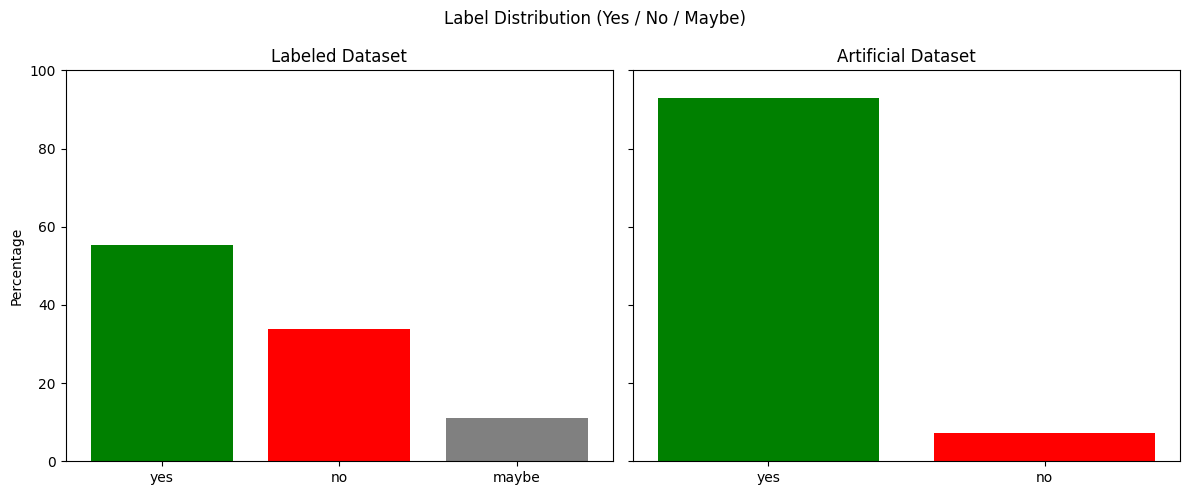

In [85]:
# Create subplots with shared y-axis to ensure the same scale across both bar plots.
# This makes it easier to visually compare the distribution of 'yes', 'no', and 'maybe' labels
# between the labeled and artificial datasets.

import matplotlib.pyplot as plt

# Count label frequencies
labeled_counts = df_labeled['final_decision'].value_counts(normalize=True) * 100  
artificial_counts = df_artificial['final_decision'].value_counts(normalize=True) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot labeled dataset
axes[0].bar(labeled_counts.index, labeled_counts.values, color=['green', 'red', 'gray'])
axes[0].set_title("Labeled Dataset")
axes[0].set_ylabel("Percentage")
axes[0].set_ylim(0, 100)

# Plot artificial dataset
axes[1].bar(artificial_counts.index, artificial_counts.values, color=['green', 'red', 'gray'])
axes[1].set_title("Artificial Dataset")
axes[1].set_ylim(0, 100)

plt.suptitle("Label Distribution (Yes / No / Maybe)")
plt.tight_layout()
plt.show()
